# **Netflix Show Clustering with K-Means**  

**Hierarchy**: Genre ➜ Rating + Duration ➜ Duration

**Data source**: TMDB “discover” endpoint (watch-provider id = 8 → Netflix)  
**Tech Stack**: Python • Pandas • Scikit-learn • Seaborn • Matplotlib  


**Install Libraries**

In [ ]:
!pip install requests tqdm python-dotenv numpy pandas scikit-learn seaborn matplotlib

**1 Setup & imports**

In [46]:
import os, requests, math, json
from pathlib import Path
from tqdm.notebook import tqdm

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

np.random.seed(42)
plt.rcParams["figure.dpi"] = 110     # sharper plots


# ---------- DATA ACQUISITION ----------

**2 Pull UK Netflix movies via TMDB API**

In [47]:
TMDB_KEY = os.getenv("TMDB_API_KEY")
BASE_URL = "https://api.themoviedb.org/3"
PROVIDER  = 8          # Netflix
REGION    = "GB"       # United Kingdom
PAGES     = 10        # 285 pages of Netflix UK titles

In [48]:
def tmdb(endpoint: str, **params):
    """Tiny TMDB GET wrapper"""
    params["api_key"] = TMDB_KEY
    r = requests.get(f"{BASE_URL}{endpoint}", params=params, timeout=30)
    r.raise_for_status()
    return r.json()

Discover movie IDs available on UK Netflix

In [49]:
ids = []
for page in tqdm(range(1, PAGES + 1), desc="Discover pages"):
    data = tmdb(
        "/discover/movie",
        watch_region=REGION,
        with_watch_providers=PROVIDER,
        page=page,
        sort_by="popularity.desc",
    )
    ids.extend([m["id"] for m in data["results"]])
    if page >= data["total_pages"]:
        break

print(f"Collected {len(ids):,} titles")

Discover pages:   0%|          | 0/10 [00:00<?, ?it/s]

Collected 200 titles


Fetch title-level details (runtime, genres, rating certificate)

In [50]:
def extract_certification(release_dates, country="UK"):
    for block in release_dates.get("results", []):
        if block["iso_3166_1"] == country:
            for entry in block["release_dates"]:
                if entry["certification"]:
                    return entry["certification"]
    return None

records = []
for mid in tqdm(ids, desc="Movie details"):
    d = tmdb(f"/movie/{mid}", append_to_response="release_dates")
    records.append(
        {
            "title":        d["title"],
            "genres":       [g["name"] for g in d["genres"]],
            "rating":       extract_certification(d["release_dates"]),
            "duration_min": d["runtime"] or np.nan,
        }
    )

Movie details:   0%|          | 0/200 [00:00<?, ?it/s]

In [51]:
df = pd.DataFrame(records).dropna(subset=["genres", "duration_min"])
print(f"Netflix UK catalogue pulled: {len(df):,} titles")

Netflix UK catalogue pulled: 199 titles


In [52]:
df

,title,genres,rating,duration_min
0,The Old Guard 2,"[Action, Fantasy]",None,107.0
1,KPop Demon Hunters,"[Animation, Fantasy, Action, Comedy, Music]",None,96.0
2,Squid Game: Fireplace,[],None,60.0
3,STRAW,"[Thriller, Drama, Crime]",None,105.0
4,Squid Game in Conversation,[Documentary],None,33.0
...,...,...,...,...
195,Ghostbusters,"[Comedy, Fantasy]",None,107.0
196,Interview with the Vampire,"[Horror, Drama, Fantasy]",None,123.0
197,Happy Gilmore,[Comedy],None,92.0
198,Trainwreck: The Astroworld Tragedy,[Documentary],None,80.0


# ---------- FEATURE ENGINEERING ----------

**3 Genre & rating one-hot, duration scaling**

Multi-label genre OHE

In [53]:
mlb = MultiLabelBinarizer()
genre_ohe = pd.DataFrame(
    mlb.fit_transform(df["genres"]),
    columns=[f"genre_{g}" for g in mlb.classes_],
    index=df.index,
)

Rating one-hot

In [54]:
ohe = OneHotEncoder(sparse=False, dtype=int, handle_unknown="ignore")
rating_ohe = pd.DataFrame(
    ohe.fit_transform(df[["rating"]]),
    columns=[f"rating_{c}" for c in ohe.categories_[0]],
    index=df.index,
)

c:\Users\eyeag\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Scaled duration

In [55]:
scaler = StandardScaler()
df["duration_scaled"] = scaler.fit_transform(df[["duration_min"]])

Unified feature matrix

In [56]:
features = pd.concat(
    [genre_ohe, rating_ohe, df[["duration_scaled"]]],
    axis=1,
)
print("Feature matrix shape:", features.shape)

Feature matrix shape: (199, 20)


# ---------- HIERARCHICAL K-MEANS ----------

**4 Parameters**

We cluster in **three layers** (tweak K’s if you like):

| Layer | Feature space           | K |
|-------|-------------------------|---|
| 1     | Genre one-hot           | 8 |
| 2     | Rating + duration       | 4 |
| 3     | Duration only           | 2 |

In [57]:
K_GENRE  = 8   # layer-1
K_RATE   = 4   # layer-2
K_DUR    = 2   # layer-3
SEED     = 42

**5 Layer 1 – genre clusters**

In [58]:
gcols = [c for c in features.columns if c.startswith("genre_")]
k1 = KMeans(n_clusters=K_GENRE, n_init="auto", random_state=SEED)
df["C1_genre"] = k1.fit_predict(features[gcols])

df["C1_genre"].value_counts().sort_index()

c:\Users\eyeag\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


C1_genre
0    37
1    27
2    19
3    32
4    25
5    23
6    15
7    21
Name: count, dtype: int64

**6 Layer 2 – rating + duration inside each genre-cluster**

In [59]:
rat_cols = [c for c in features.columns if c.startswith("rating_")]
for g in sorted(df["C1_genre"].unique()):
    mask = df["C1_genre"] == g
    Xsub = pd.concat([features.loc[mask, rat_cols], df.loc[mask, ["duration_scaled"]]], axis=1)
    
    k2 = KMeans(n_clusters=K_RATE, n_init="auto", random_state=SEED)
    df.loc[mask, "C2_rate"] = k2.fit_predict(Xsub).astype(int)

df.groupby(["C1_genre", "C2_rate"]).size().unstack(fill_value=0).head()

c:\Users\eyeag\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\eyeag\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\eyeag\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\eyeag\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

C2_rate,0.0,1.0,2.0,3.0
C1_genre,,,,
0,10,13,1,13
1,10,7,4,6
2,8,6,4,1
3,19,1,3,9
4,8,3,3,11


**7 Layer 3 – duration split inside each (genre × rating)**

In [60]:
for g, r in df[["C1_genre", "C2_rate"]].drop_duplicates().values:
    mask = (df["C1_genre"] == g) & (df["C2_rate"] == r)
    Xsub = df.loc[mask, ["duration_scaled"]]
    
    if len(Xsub) < K_DUR:        # avoid errors on tiny groups
        df.loc[mask, "C3_dur"] = 0
        continue
    
    k3 = KMeans(n_clusters=K_DUR, n_init="auto", random_state=SEED)
    df.loc[mask, "C3_dur"] = k3.fit_predict(Xsub).astype(int)

# Unified hierarchical label for plotting
df["cluster_label"] = (
    "G" + df["C1_genre"].astype(int).astype(str) + "_" +
    "R" + df["C2_rate"].astype(int).astype(str)  + "_" +
    "D" + df["C3_dur"].astype(int).astype(str)
)

c:\Users\eyeag\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\eyeag\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\eyeag\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\eyeag\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Window

# ---------- VISUALISATIONS ----------

**8 PCA scatter coloured by full label**

C:\Users\eyeag\AppData\Local\Temp\ipykernel_1636\398111677.py:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


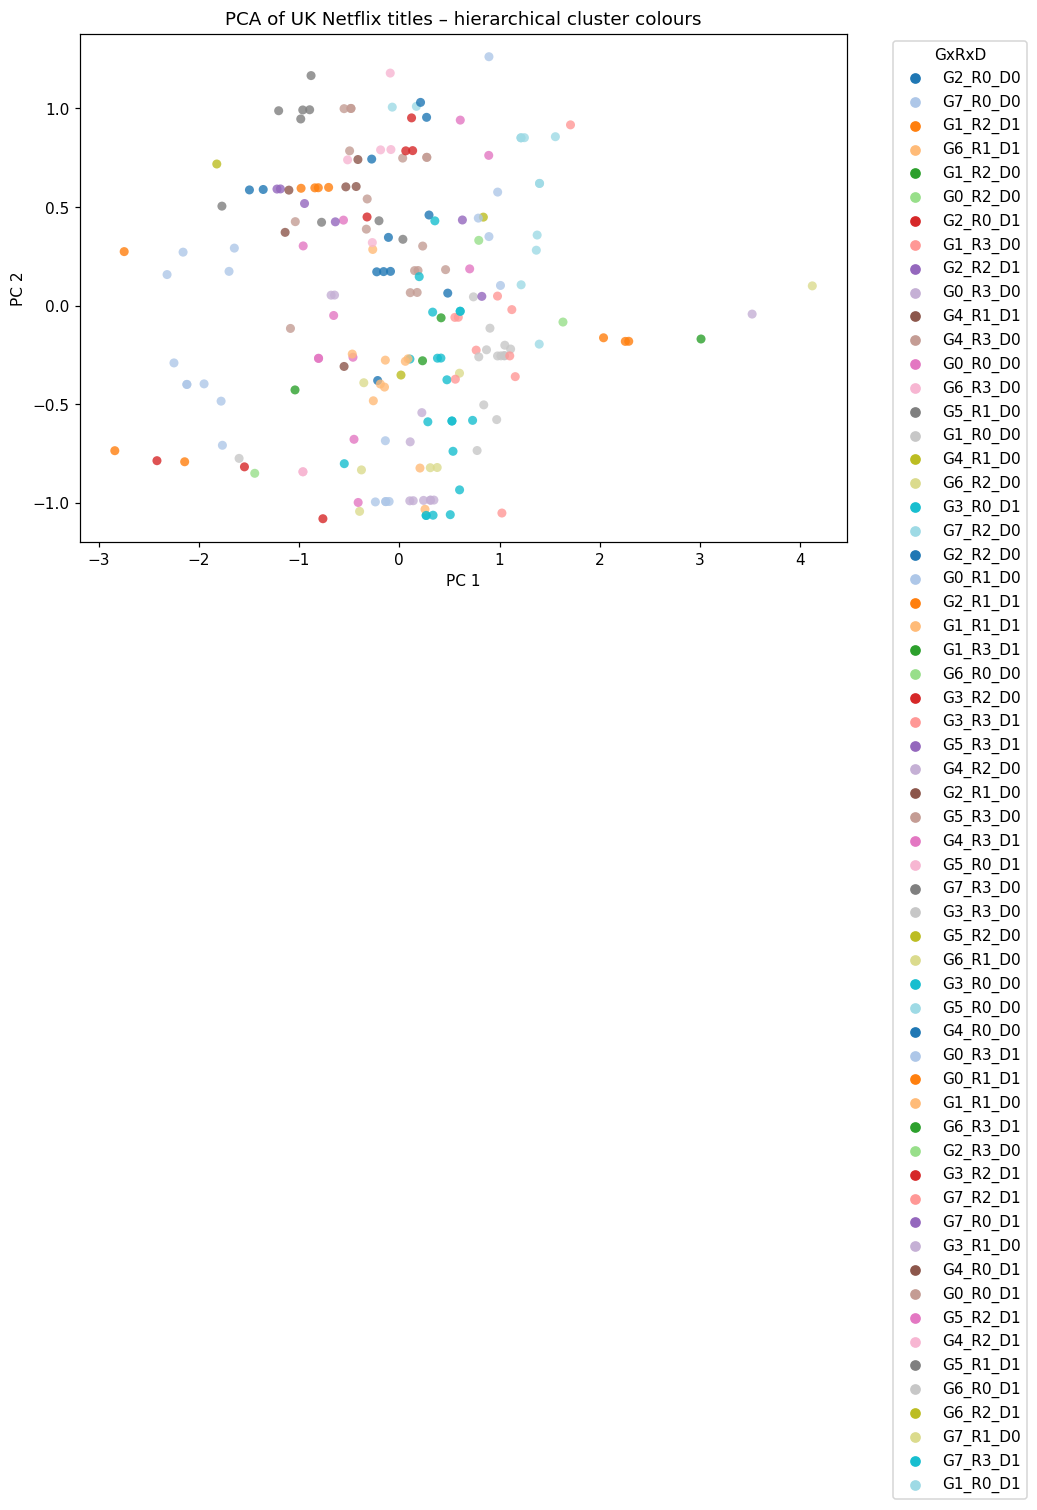

In [61]:
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(features)

plt.figure(figsize=(9,6))
sns.scatterplot(
    x=coords[:,0], y=coords[:,1],
    hue=df["cluster_label"],
    palette="tab20", s=35, alpha=0.8, linewidth=0
)
plt.title("PCA of UK Netflix titles – hierarchical cluster colours")
plt.xlabel("PC 1"); plt.ylabel("PC 2")
plt.legend(bbox_to_anchor=(1.05,1), title="GxRxD", ncol=1)
plt.tight_layout()
plt.show()

**9 Interactive sunburst (genre → rating → duration)**

In [62]:
sun = px.sunburst(
    df,
    path=["C1_genre", "C2_rate", "C3_dur"],
    values=None,
    color="C1_genre",
    color_continuous_scale="Tealgrn",
    title="Hierarchical cluster breakdown",
)
sun.update_layout(margin=dict(t=40, l=0, r=0, b=0))
sun.show()